# Enrichment Analysis Notebook

Compares the results of SPINDOCTOR gene set summarization vs statistical ontological enrichment.

Draft: https://docs.google.com/document/d/1H103ux6Dd1_bPM0un4RwutBLcYJx-0ybil2AwlAvG_Q/edit#

## Initial setup

Here we take care of imports, defining the data dictionary for the pandas dataframes

In [224]:
import yaml
from yaml import Loader
from collections import defaultdict
import pandas as pd
import numpy as np
from scipy.stats import kstest, ttest_ind, wilcoxon, mannwhitneyu
import math
from statsmodels.stats.multitest import multipletests

#import itertools as it
#import collections as ct
#import more_itertools as mit

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import colorsys
import seaborn as sns

from oaklib import get_adapter
from oaklib.datamodels.vocabulary import IS_A, PART_OF
from ontogpt.evaluation.enrichment.eval_enrichment import EvalEnrichment
go = get_adapter("sqlite:obo:go")
hgnc = get_adapter("sqlite:obo:hgnc")

In [187]:
TURBO = "gpt-3.5-turbo"
DAVINCI = "text-davinci-003"
GPT4 = "gpt-4"
MODELS = [TURBO, DAVINCI, GPT4]

In [188]:
df = pd.read_csv('results/processed.tsv', sep='\t', header=0, index_col=0)
df

name  \
go_term_ids                                                                          
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...        glycolysis-gocam-0-0.005   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...        glycolysis-gocam-0-0.005   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...        glycolysis-gocam-0-0.005   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...        glycolysis-gocam-0-0.005   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...        glycolysis-gocam-0-0.005   
...                                                                            ...   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...  HALLMARK_MTORC1_SIGNALING-1-99   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...  HALLMARK_MTORC1_SIGNALING-1-99   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...  HALLMARK_MTORC1_SIGNALING-1-99   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...  HALLMARK_MTORC1_SIGNALING-1-99   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...  HALLMARK_MTORC1_SIGNALING-1-99   

                                                    cutoff  closure  top_n  \
go_term_ids                                                                  
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...   0.005    False      1   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...   0.005    False      5   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...   0.005    False     10   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...   0.005    False     25   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...   0.005    False   5000   
...                                                    ...      ...    ...   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...  99.000     True      1   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...  99.000     True      5   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...  99.000     True     10   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...  99.000     True     25   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...  99.000     True   5000   

                                                   source  model method  \
go_term_ids                                                               
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...   NONE    4.0    gpt   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...   NONE    4.0    gpt   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...   NONE    4.0    gpt   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...   NONE    4.0    gpt   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...   NONE    4.0    gpt   
...                                                   ...    ...    ...   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...    NaN    NaN    NaN   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...    NaN    NaN    NaN   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...    NaN    NaN    NaN   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...    NaN    NaN    NaN   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...    NaN    NaN    NaN   

                                                      method_desc  \
go_term_ids                                                         
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...  no_synopsis-4   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...  no_synopsis-4   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...  no_synopsis-4   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...  no_synopsis-4   
{'BFO:0000015', 'GO:0032787', 'GO:0043436', 'GO...  no_synopsis-4   
...                                                           ...   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...            NaN   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...            NaN   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...            NaN   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...            NaN   
{'GO:0051348', 'GO:0005976', 'GO:0035524', 'GO:...            NaN   

                                                                     r

In [189]:
grouped_data = df.groupby(['source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

# Calculate precision, recall, and F1-score for each group
grouped_data['precision'] = grouped_data['true_positives'] / (grouped_data['true_positives'] + grouped_data['false_positives'])
grouped_data['recall'] = grouped_data['true_positives'] / (grouped_data['true_positives'] + grouped_data['false_negatives'])
grouped_data['f1_score'] = 2 * ((grouped_data['precision'] * grouped_data['recall']) / (grouped_data['precision'] + grouped_data['recall']))
grouped_data

,source,model,method,true_positives,false_positives,false_negatives,precision,recall,f1_score
0,GO,3.0,gpt,34422,37679,1503266,0.477414,0.022386,0.042766
1,GO,3.5,gpt,34442,15682,1503246,0.687136,0.022399,0.043383
2,GO,4.0,gpt,62266,24846,1475422,0.714781,0.040493,0.076645
3,NONE,3.0,gpt,36064,17518,1501624,0.673062,0.023453,0.045327
4,NONE,3.5,gpt,49290,19513,1488398,0.716393,0.032055,0.061364
5,NONE,4.0,gpt,51721,19867,1485967,0.722481,0.033636,0.064279
6,RefSeq,3.0,gpt,40513,22958,1497175,0.638292,0.026347,0.050605
7,RefSeq,3.5,gpt,43651,15917,1494037,0.732793,0.028387,0.054657
8,RefSeq,4.0,gpt,44386,19495,1493302,0.694823,0.028865,0.055428


In [190]:
grouped_data_cutoff_combination = df.groupby(['cutoff', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

# Calculate precision, recall, and F1-score for each group
grouped_data_cutoff_combination['precision'] = grouped_data_cutoff_combination['true_positives'] / (grouped_data_cutoff_combination['true_positives'] + grouped_data_cutoff_combination['false_positives'])
grouped_data_cutoff_combination['recall'] = grouped_data_cutoff_combination['true_positives'] / (grouped_data_cutoff_combination['true_positives'] + grouped_data_cutoff_combination['false_negatives'])
grouped_data_cutoff_combination['f1_score'] = 2 * ((grouped_data_cutoff_combination['precision'] * grouped_data_cutoff_combination['recall']) / (grouped_data_cutoff_combination['precision'] + grouped_data_cutoff_combination['recall']))
grouped_data_cutoff_combination

,cutoff,source,model,method,true_positives,false_positives,false_negatives,precision,recall,f1_score
0,0.005,GO,3.0,gpt,5268,13486,96076,0.280900,0.051981,0.087728
1,0.005,GO,3.5,gpt,6792,5541,94552,0.550718,0.067019,0.119496
2,0.005,GO,4.0,gpt,10514,8843,90830,0.543163,0.103746,0.174216
3,0.005,NONE,3.0,gpt,4974,6240,96370,0.443553,0.049080,0.088381
4,0.005,NONE,3.5,gpt,10153,6867,91191,0.596533,0.100184,0.171556
5,0.005,NONE,4.0,gpt,9419,7042,91925,0.572201,0.092941,0.159908
6,0.005,RefSeq,3.0,gpt,5371,8163,95973,0.396852,0.052998,0.093508
7,0.005,RefSeq,3.5,gpt,8672,5621,92672,0.606731,0.085570,0.149987
8,0.005,RefSeq,4.0,gpt,7992,6932,93352,0.535513,0.078860,0.137475
9,0.050,GO,3.0,gpt,6067,13229,119291,0.314417,0.048397,0.083883


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_7257/517692930.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_7257/517692930.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_combination['label_order'] = data_combination['label'].apply(label_order)
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw000

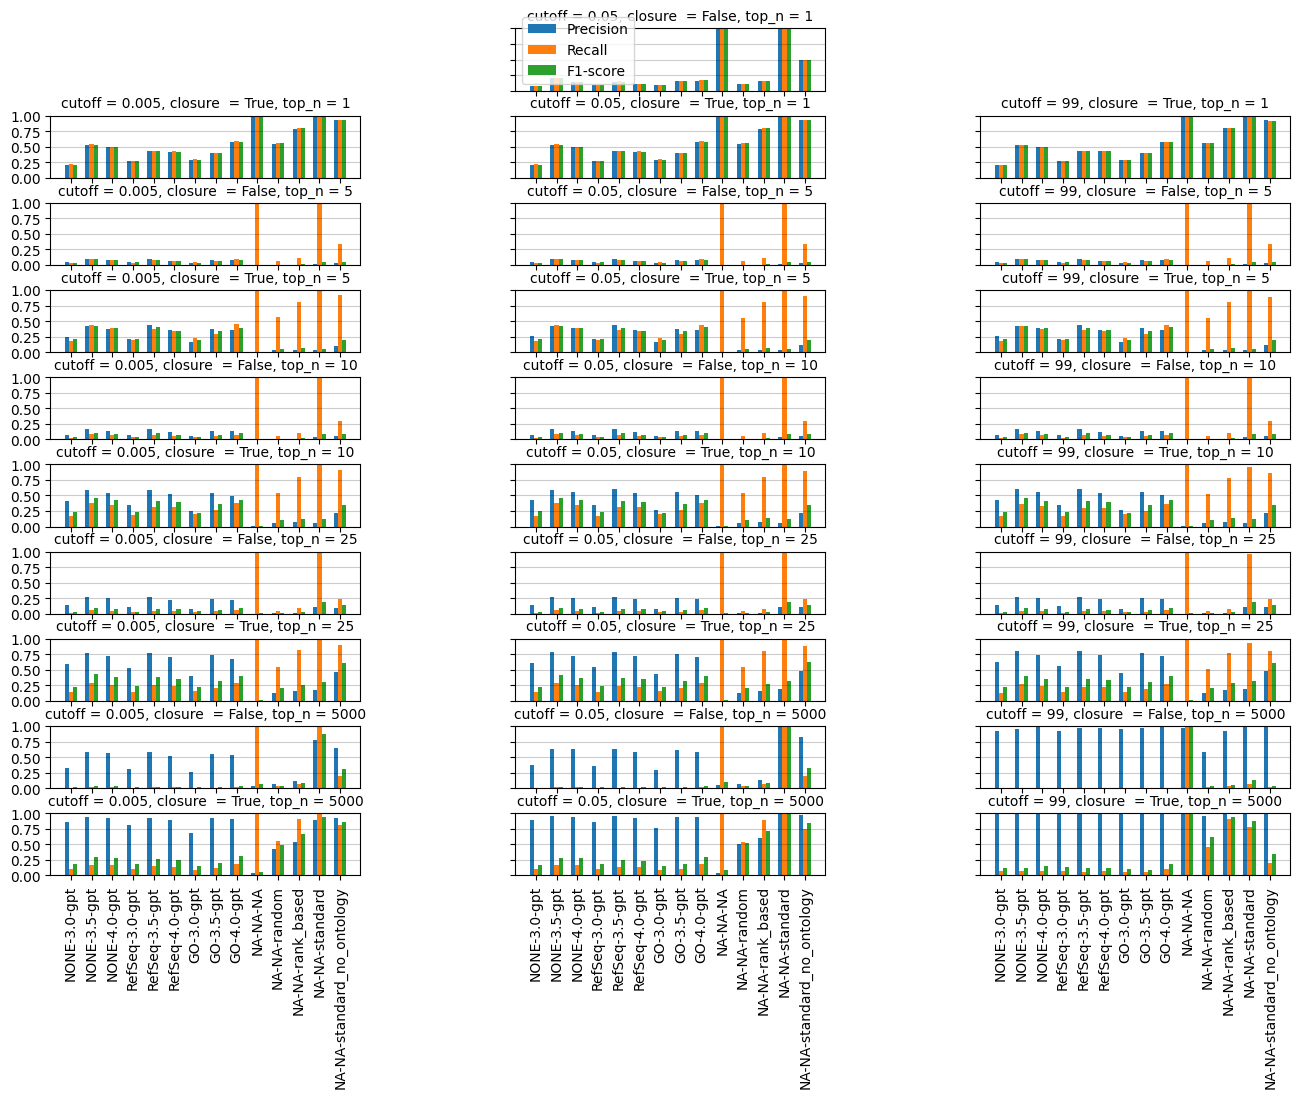

In [222]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end


cutoff_values = sorted([0.05, 0.005, 99])

data_filled = df.fillna("NA")

grouped_data_filled = data_filled.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])

unique_combinations_closure_topn = sorted(grouped_data_filled[['closure', 'top_n']].drop_duplicates().values, key=lambda x: (x[1], x[0]))

num_rows = len(unique_combinations_closure_topn)
num_cols = len(cutoff_values)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(16, 11), gridspec_kw={"hspace": 0.4, "wspace": 0.5})
        
for row_idx, (closure, top_n) in enumerate(unique_combinations_closure_topn):
    for col_idx, cutoff in enumerate(cutoff_values):
        
        if (col_idx < 1 or col_idx >= num_cols - 1) and (row_idx == 0 or row_idx == 1):
            ax[row_idx, col_idx].axis('off') 
            continue
            
        data_combination = grouped_data_filled[(grouped_data_filled['cutoff'] == cutoff) & (grouped_data_filled['closure'] == closure) & (grouped_data_filled['top_n'] == top_n)]
        data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']

        # Sort data_combination based on the label_order
        data_combination['label_order'] = data_combination['label'].apply(label_order)
        data_combination = data_combination.sort_values('label_order')
        
        x_newest = np.arange(len(data_combination['label']))
        width_newest = 0.2

        ax[row_idx, col_idx].bar(x_newest - width_newest, data_combination['precision'], width_newest, label='Precision')
        ax[row_idx, col_idx].bar(x_newest, data_combination['recall'], width_newest, label='Recall')
        ax[row_idx, col_idx].bar(x_newest + width_newest, data_combination['f1_score'], width_newest, label='F1-score')
        
        ax[row_idx, col_idx].set_title(f'cutoff = {cutoff}, closure  = {closure}, top_n = {top_n}', fontsize=10)
        
        ax[row_idx, col_idx].set_ylim(0, 1)
        
        # Change y-axis tick marks
        ax[row_idx, col_idx].set_yticks(np.arange(0, 1.1, 0.25))
        if col_idx != 0:  # Hide y-axis labels for non-left columns
            ax[row_idx, col_idx].set_yticklabels([])
        
        # Set x-axis ticks
        ax[row_idx, col_idx].set_xticks(x_newest)
        if row_idx == num_rows - 1:  # Adjusting the condition for x-tick labels for the last row
            ax[row_idx, col_idx].set_xticklabels(data_combination['label'], rotation=90)
        else:
            ax[row_idx, col_idx].set_xticklabels([])
    
        # Add horizontal gridlines
        ax[row_idx, col_idx].grid(axis='y', which='major', color='black', alpha=0.2)
    
        if row_idx == 0 and col_idx == num_cols - 2:
            ax[row_idx, col_idx].legend()

plt.tight_layout()
plt.savefig("process_precision_recall_allGPT.pdf", format="pdf", bbox_inches="tight")
plt.show()


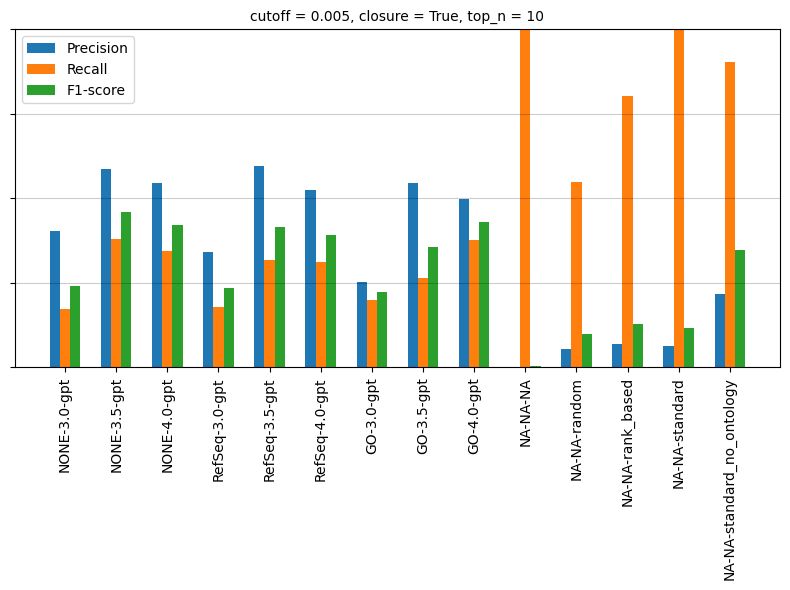

In [192]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end


data_filled = df.fillna("NA")
condition = (
    (data_filled['cutoff'] == 0.005) &
    (data_filled['closure'] == True) &
    (data_filled['top_n'] == 10)
)
filtered_data = data_filled[condition]
filtered_data.reset_index(drop=True, inplace=True)

grouped_data_filled = filtered_data.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])


fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a single subplot

data_combination = grouped_data_filled#filtered_data[(filtered_data['cutoff'] == 0.005) & (filtered_data['closure'] == True) & (filtered_data['top_n'] == 10)]
data_combination['label'] = data_combination['source'] + '-' + data_combination['model'].astype(str) + '-' + data_combination['method']

# Sort data_combination based on the label_order
data_combination['label_order'] = data_combination['label'].apply(label_order)
data_combination = data_combination.sort_values('label_order')

x_newest = np.arange(len(data_combination['label']))
width_newest = 0.2

ax.bar(x_newest - width_newest, data_combination['precision'], width_newest, label='Precision')
ax.bar(x_newest, data_combination['recall'], width_newest, label='Recall')
ax.bar(x_newest + width_newest, data_combination['f1_score'], width_newest, label='F1-score')

ax.set_title(f'cutoff = 0.005, closure = True, top_n = 10', fontsize=10)

ax.set_ylim(0, 1)

# Change y-axis tick marks
ax.set_yticks(np.arange(0, 1.1, 0.25))
ax.set_yticklabels([])  # Hide y-axis labels

# Set x-axis ticks
ax.set_xticks(x_newest)
ax.set_xticklabels(data_combination['label'], rotation=90)

# Add horizontal gridlines
ax.grid(axis='y', which='major', color='black', alpha=0.2)
ax.legend()

plt.tight_layout()
plt.savefig("process_precision_recall_specific_0.005_true_10.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [193]:
filtered_data['method'] = filtered_data['method'].str.upper()

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_7257/3772999966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['method'] = filtered_data['method'].str.upper()


In [194]:
filtered_data['method']

0                        GPT
1                        GPT
2                        GPT
3                        GPT
4                        GPT
                ...         
3307                STANDARD
3308    STANDARD_NO_ONTOLOGY
3309                  RANDOM
3310              RANK_BASED
3311                      NA
Name: method, Length: 3312, dtype: object

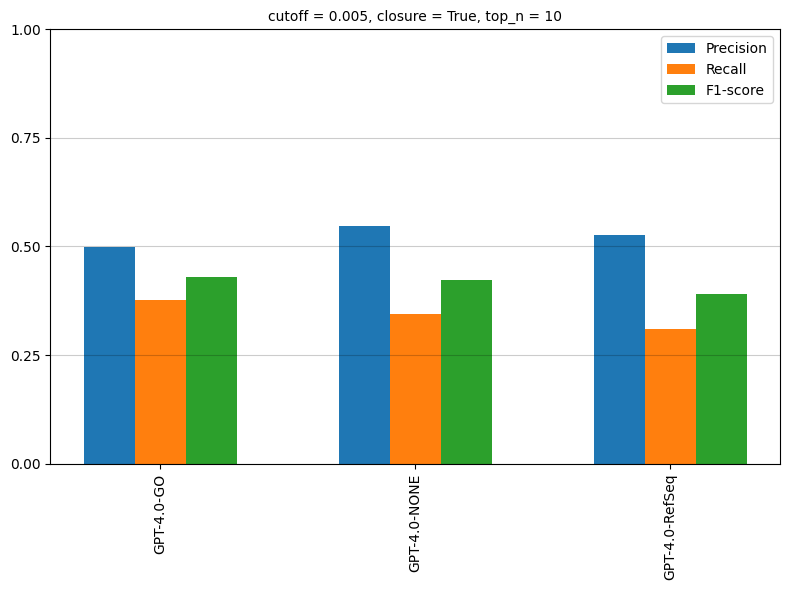

In [195]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end

data_filled = df.fillna("NA")
condition = (
    (data_filled['cutoff'] == 0.005) &
    (data_filled['closure'] == True) &
    (data_filled['top_n'] == 10) &
    (data_filled['model'] == 4.0)
)
filtered_data = data_filled[condition]
filtered_data.reset_index(drop=True, inplace=True)

grouped_data_filled = filtered_data.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])

# Filter out sets with 'NA-NA' label prefix
filtered_data_combination = grouped_data_filled[~grouped_data_filled['source'].str.startswith('NA')]

filtered_data_combination['method'] = filtered_data_combination['method'].str.upper()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a single subplot

filtered_data_combination['label'] = filtered_data_combination['method'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['source']


# Sort data_combination based on the label_order
filtered_data_combination['label_order'] = filtered_data_combination['label'].apply(label_order)
filtered_data_combination = filtered_data_combination.sort_values('label_order')

x_newest = np.arange(len(filtered_data_combination['label']))
width_newest = 0.2

ax.bar(x_newest - width_newest, filtered_data_combination['precision'], width_newest, label='Precision')
ax.bar(x_newest, filtered_data_combination['recall'], width_newest, label='Recall')
ax.bar(x_newest + width_newest, filtered_data_combination['f1_score'], width_newest, label='F1-score')

ax.set_title(f'cutoff = 0.005, closure = True, top_n = 10', fontsize=10)

ax.set_ylim(0, 0.75)

# Change y-axis tick marks
ax.set_yticks(np.arange(0, 1.1, 0.25))
#ax.set_yticklabels([])  # Hide y-axis labels

# Set x-axis ticks
ax.set_xticks(x_newest)
ax.set_xticklabels(filtered_data_combination['label'], rotation=90)

# Add horizontal gridlines
ax.grid(axis='y', which='major', color='black', alpha=0.2)
ax.legend()

plt.tight_layout()
plt.savefig("process_precision_recall_specific_0.005_true_10__gpt4.pdf", format="pdf", bbox_inches="tight")
plt.show()

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_7257/4055787024.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_combination['method'] = filtered_data_combination['method'].str.upper()
/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_7257/4055787024.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_combination['label'] = filtered_data_combination['method'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['source'

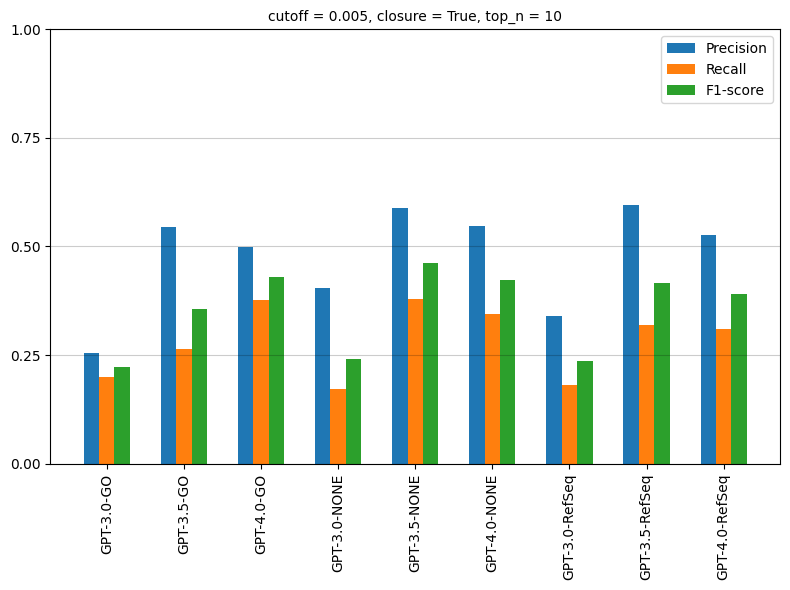

In [196]:
def custom_order(label):
    prefix_order = ["NONE", "RefSeq", "GO", "NA"]
    suffix_order = ["3.0-GPT", "3.5GPT", "4.0-GPT"]
    
    try:
        prefix_parts = label.split('-')
        prefix_weight = prefix_order.index(prefix_parts[0])
        
        suffix = '-'.join(prefix_parts[1:])
        suffix_weight = suffix_order.index(suffix)
    except ValueError:
        return (999, 999)  # put unexpected values at the end
    
    return prefix_weight, suffix_weight

def label_order(label):
    prefixes = ["NONE", "RefSeq", "GO", "NA"]
    for i, prefix in enumerate(prefixes):
        if label.startswith(prefix):
            return i
    return len(prefixes)  # Return a value that puts any other labels at the end

data_filled = df.fillna("NA")
condition = (
    (data_filled['cutoff'] == 0.005) &
    (data_filled['closure'] == True) &
    (data_filled['top_n'] == 10)
)
filtered_data = data_filled[condition]
filtered_data.reset_index(drop=True, inplace=True)

grouped_data_filled = filtered_data.groupby(['cutoff', 'closure', 'top_n', 'source', 'model', 'method'])[['true_positives', 'false_positives', 'false_negatives']].sum().reset_index()

grouped_data_filled['precision'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_positives'])
grouped_data_filled['recall'] = grouped_data_filled['true_positives'] / (grouped_data_filled['true_positives'] + grouped_data_filled['false_negatives'])
grouped_data_filled['f1_score'] = 2 * ((grouped_data_filled['precision'] * grouped_data_filled['recall']) / (grouped_data_filled['precision'] + grouped_data_filled['recall']))

grouped_data_filled['sort_order'] = grouped_data_filled['source'].apply(custom_order)
grouped_data_filled = grouped_data_filled.sort_values(['sort_order', 'top_n', 'closure'])

# Filter out sets with 'NA-NA' label prefix
filtered_data_combination = grouped_data_filled[~grouped_data_filled['source'].str.startswith('NA')]

filtered_data_combination['method'] = filtered_data_combination['method'].str.upper()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Create a single subplot

#filtered_data_combination['label'] = filtered_data_combination['source'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['method']
filtered_data_combination['label'] = filtered_data_combination['method'] + '-' + filtered_data_combination['model'].astype(str) + '-' + filtered_data_combination['source']


# Sort data_combination based on the label_order
filtered_data_combination['label_order'] = filtered_data_combination['label'].apply(label_order)
filtered_data_combination = filtered_data_combination.sort_values('label_order')

x_newest = np.arange(len(filtered_data_combination['label']))
width_newest = 0.2

ax.bar(x_newest - width_newest, filtered_data_combination['precision'], width_newest, label='Precision')
ax.bar(x_newest, filtered_data_combination['recall'], width_newest, label='Recall')
ax.bar(x_newest + width_newest, filtered_data_combination['f1_score'], width_newest, label='F1-score')

ax.set_title(f'cutoff = 0.005, closure = True, top_n = 10', fontsize=10)

ax.set_ylim(0, 1)

# Change y-axis tick marks
ax.set_yticks(np.arange(0, 1.1, 0.25))
#ax.set_yticklabels([])  # Hide y-axis labels

# Set x-axis ticks
ax.set_xticks(x_newest)
ax.set_xticklabels(filtered_data_combination['label'], rotation=90)

# Add horizontal gridlines
ax.grid(axis='y', which='major', color='black', alpha=0.2)
ax.legend()

plt.tight_layout()
plt.savefig("process_precision_recall_specific_0.005_true_10.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [197]:
print(filtered_data.shape)
filtered_data.columns

(3312, 30)


Index(['name', 'cutoff', 'closure', 'top_n', 'source', 'model', 'method',
       'method_desc', 'run', 'truncation_factor', 'prompt_variant',
       'response_token_length', 'prompt_length', 'true_positives',
       'false_positives', 'false_negatives', 'more_general_false_negatives',
       'more_specific_false_negatives', 'all_predictions_closure', 'unparsed',
       'true_positive_terms', 'false_positive_terms',
       'false_negative_terms_example20', 'unparsed_terms', 'gene_set_size',
       'precision', 'recall', 'recall_general', 'recall_specific', 'f1_score'],
      dtype='object')

In [198]:
filtered_data_dropna = filtered_data[filtered_data['model'] != 'NA']

In [199]:
filtered_data_dropna['method'] = filtered_data_dropna['method'].str.upper()

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_7257/3079728095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna['method'] = filtered_data_dropna['method'].str.upper()


In [200]:
method_model_combinations = filtered_data_dropna.groupby(['method', 'model', 'source'])
method_model_combinations.head()

,name,cutoff,closure,top_n,source,model,method,method_desc,run,truncation_factor,...,true_positive_terms,false_positive_terms,false_negative_terms_example20,unparsed_terms,gene_set_size,precision,recall,recall_general,recall_specific,f1_score
0,glycolysis-gocam-0-0.005,0.005,True,10,NONE,4.0,GPT,no_synopsis-4,gpt-4.no_synopsis.v1,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,energy production|atp generation,10,1.000000,0.400000,0.666667,0.800000,0.571429
1,glycolysis-gocam-0-0.005,0.005,True,10,NONE,4.0,GPT,no_synopsis-4,gpt-4.no_synopsis.v2,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,energy production|atp generation,10,1.000000,0.400000,0.666667,0.800000,0.571429
2,glycolysis-gocam-0-0.005,0.005,True,10,GO,4.0,GPT,ontological_synopsis-4,gpt-4.ontological_synopsis.v1,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094|GO...,GO:0045766,GO:0048029|GO:007006,fructose binding activity|phosphotransferase a...,10,0.833333,0.500000,0.625000,0.833333,0.625
3,glycolysis-gocam-0-0.005,0.005,True,10,GO,4.0,GPT,ontological_synopsis-4,gpt-4.ontological_synopsis.v2,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094|GO...,GO:0046716|GO:0010595|GO:0002639,GO:0048029|GO:007006,glucose-6-phosphate metabolic process,10,0.625000,0.500000,0.625000,0.833333,0.555556
4,glycolysis-gocam-0-0.005,0.005,True,10,RefSeq,4.0,GPT,narrative_synopsis-4,gpt-4.narrative_synopsis.v1,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,energy production|atp generation,10,1.000000,0.400000,0.666667,0.800000,0.571429
5,glycolysis-gocam-0-0.005,0.005,True,10,RefSeq,4.0,GPT,narrative_synopsis-4,gpt-4.narrative_synopsis.v2,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,atp production|energy-yielding step|reversible...,10,1.000000,0.400000,0.666667,0.800000,0.571429
6,glycolysis-gocam-0-0.005,0.005,True,10,NONE,3.5,GPT,no_synopsis-3.5,gpt-3.5-turbo.no_synopsis.v1,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,NA,10,1.000000,0.400000,0.666667,1.000000,0.571429
7,glycolysis-gocam-0-0.005,0.005,True,10,NONE,3.5,GPT,no_synopsis-3.5,gpt-3.5-turbo.no_synopsis.v2,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,NA,10,1.000000,0.400000,0.666667,0.800000,0.571429
8,glycolysis-gocam-0-0.005,0.005,True,10,GO,3.5,GPT,ontological_synopsis-3.5,gpt-3.5-turbo.ontological_synopsis.v1,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094|GO...,GO:0019725|GO:0008104|GO:0005634,GO:0048029|GO:000582,NA,10,0.625000,0.500000,0.625000,0.833333,0.555556
9,glycolysis-gocam-0-0.005,0.005,True,10,GO,3.5,GPT,ontological_synopsis-3.5,gpt-3.5-turbo.ontological_synopsis.v2,1.0,...,GO:0006096|GO:0019318|GO:0061621|GO:0006094,NA,GO:0048029|GO:007006,metabolic homeostasis,10,1.000000,0.400000,0.666667,0.800000,0.571429


In [201]:
method_model_combinations_columns = method_model_combinations[['method', 'model', 'source']]
#unique_rows = selected_columns.drop_duplicates()
unique_rows_df = pd.DataFrame(columns=['method', 'model', 'source'])

for group_name, group_data in method_model_combinations_columns:
    unique_rows = group_data.drop_duplicates()
    unique_rows_df = pd.concat([unique_rows_df, unique_rows])

print(unique_rows_df.shape)
unique_rows_df

(9, 3)


,method,model,source
14,GPT,3.0,GO
12,GPT,3.0,NONE
16,GPT,3.0,RefSeq
8,GPT,3.5,GO
6,GPT,3.5,NONE
10,GPT,3.5,RefSeq
2,GPT,4.0,GO
0,GPT,4.0,NONE
4,GPT,4.0,RefSeq


In [202]:
import pandas as pd
from itertools import product

all_methods = ['GPT']
all_models = [3.0, 3.5, 4.0]
all_sources = ['NONE', 'RefSeq', 'GO']

all_possible_combinations_list = list(product(all_methods, all_models, all_sources))
all_possible_combinations = pd.DataFrame(all_possible_combinations_list, columns=['method', 'model', 'source'])

# Create a set of unique combinations from method_model_combinations
existing_combinations = set(method_model_combinations.groups.keys())
print(f'len existing: {len(existing_combinations)}')
print(existing_combinations)

# Create a set of all possible combinations
all_possible_combinations_set = set(map(tuple, all_possible_combinations.values))
print(f'len possible: {len(all_possible_combinations_set)}')
print(all_possible_combinations_set)


len existing: 9
{('GPT', 3.0, 'RefSeq'), ('GPT', 4.0, 'NONE'), ('GPT', 3.5, 'GO'), ('GPT', 4.0, 'GO'), ('GPT', 3.5, 'NONE'), ('GPT', 3.0, 'GO'), ('GPT', 3.0, 'NONE'), ('GPT', 4.0, 'RefSeq'), ('GPT', 3.5, 'RefSeq')}
len possible: 9
{('GPT', 3.0, 'RefSeq'), ('GPT', 4.0, 'NONE'), ('GPT', 3.5, 'GO'), ('GPT', 4.0, 'GO'), ('GPT', 3.5, 'NONE'), ('GPT', 3.0, 'GO'), ('GPT', 3.0, 'NONE'), ('GPT', 4.0, 'RefSeq'), ('GPT', 3.5, 'RefSeq')}


In [203]:
# Check for missing combinations
missing_combinations1 = all_possible_combinations_set - existing_combinations
print(missing_combinations1)
missing_combinations2 = existing_combinations - all_possible_combinations_set
print(missing_combinations2)
# Convert the missing combinations back to a DataFrame if needed
missing_combinations_df = pd.DataFrame(list(missing_combinations1), columns=['method', 'model', 'source'])

# Display the missing combinations
print("Missing combinations")
print(missing_combinations_df)

set()
set()
Missing combinations
Empty DataFrame
Columns: [method, model, source]
Index: []


In [204]:
filtered_data_dropna['f1_score'].isna().sum()

0

In [205]:
filtered_data_dropna['f1_score'].unique()

array([0.5714285714285714, 0.625, 0.5555555555555556, 0.0,
       0.4615384615384615, 0.4210526315789473, 0.7058823529411765, 0.6,
       0.4, 0.5454545454545454, 0.6666666666666666, 0.7272727272727273,
       0.5, 0.4705882352941176, 'NA', 0.8421052631578947,
       0.4285714285714285, 0.7619047619047619, 0.6956521739130435,
       0.3636363636363636, 0.125, 0.3, 0.8, 0.8333333333333334,
       0.6451612903225806, 0.9090909090909092, 0.1538461538461538,
       0.2307692307692307, 0.8695652173913043, 0.1818181818181818,
       0.5882352941176471, 0.4444444444444444, 0.375, 0.2857142857142857,
       0.5333333333333333, 0.3333333333333333, 0.3076923076923077, 0.9,
       0.631578947368421, 0.3157894736842105, 0.3529411764705882,
       0.6086956521739131, 0.2105263157894736, 0.4761904761904761,
       0.7368421052631579, 0.25, 0.1428571428571428, 0.2352941176470588,
       0.1666666666666666, 0.2666666666666666, 0.1904761904761904,
       0.7777777777777778, 0.1333333333333333, 0.117647

In [206]:
method_model_combinations

In [207]:
metrics = ['f1_score']

t_test_results = []
pairs_with_na = []
all_possible_pairs = list(product(method_model_combinations, repeat=2))

# Perform pairwise t-tests for each metric
for metric in metrics:
    filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')

    for (key1, group1), (key2, group2) in all_possible_pairs:#existing_combinations:#:#all_possible_combinations_list:#
        print(f'1: {key1}\t2: {key2}')

        group1_metric = pd.to_numeric(group1[metric], errors='coerce').dropna()
        group2_metric = pd.to_numeric(group2[metric], errors='coerce').dropna()

        t_stat, p_value = ttest_ind(group1_metric, group2_metric, 
                                    nan_policy='propagate', permutations=100000, alternative='greater',
                                   equal_var='false')
        
        # Store the results
        t_test_results.append({
            'Method1': key1[0],
            'Model1': key1[1],
            'Source1': key1[2],
            'Method2': key2[0],
            'Model2': key2[1],
            'Source2': key2[2],
            'Metric': metric,
            'T-Statistic': t_stat,
            'P-Value': p_value,
        })

        '''#example output
        if key1 == ('GPT', 3.5, 'NONE') and key2 == ('GPT', 3.0, 'NONE'):
            print(f'1: {key1}\t2: {key2}')
            testres = ttest_ind(group1_metric, group2_metric, 
                                    nan_policy='propagate', permutations=100000, alternative='greater',
                                   equal_var='false')
            print(str(testres))
            print(type(group1[metric]))
            print(group1_metric)
            print(group2_metric)
            print(group1_metric[group1_metric.isna()])
            print(group2_metric[group2_metric.isna()])
            print(f'1: {group1[metric].isna().sum()}\t2: {group2_metric.isna().sum()}')
            print(f'group1: {len(group1_metric)}, group2: {len(group2_metric)}')
            print(t_test_results[-1])'''

# Create a DataFrame to display the results
t_test_results_df = pd.DataFrame(t_test_results)

# Display the results
#print("Pairwise t-test results:")
#print(significant_results)

#print("pairs_with_na")
#print(pairs_with_na)

1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'GO')


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_7257/2572284867.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.5, 'GO')


In [208]:
t_test_results_df.to_csv('t_test_results_f1.tsv', sep='\t', index=False)
#t_test_results_df = pd.read_csv('t_test_results_f1.tsv', sep='\t')

In [209]:
print(f'len: {len(all_possible_pairs)}')
print(f'len: {len(all_possible_pairs[5])}')
print(f'len: {len(all_possible_pairs[5][0])}')
print(f'len: {len(all_possible_pairs[5][1])}')
print(type(all_possible_pairs[5][0][0]))
all_possible_pairs[5][0][0]
#all_possible_pairs[5][1]

len: 81
len: 2
len: 2
len: 2
<class 'tuple'>


('GPT', 3.0, 'GO')

In [210]:
# You can filter the results based on a significance level (e.g., 0.05) if needed
#significance_level = 0.05
#significant_results = t_test_results_df[t_test_results_df['P-Value'] < significance_level]

In [211]:
t_test_results_df['Method-Model-Source-1 >'] = t_test_results_df['Method1'].str.upper() + '-' + t_test_results_df['Model1'].astype(str) + '-' + t_test_results_df['Source1']
t_test_results_df['< Method-Model-Source-2'] = t_test_results_df['Method2'].str.upper() + '-' + t_test_results_df['Model2'].astype(str) + '-' + t_test_results_df['Source2']

#print(significant_results['Method+Model+Source 1'])

# Pivot the dataframe
heatmap_data = t_test_results_df.pivot(index='Method-Model-Source-1 >', columns='< Method-Model-Source-2', values='P-Value')
heatmap_data = heatmap_data[heatmap_data.index]
heatmap_data = heatmap_data.iloc[::-1]
print(heatmap_data.shape)
heatmap_data

(9, 9)


< Method-Model-Source-2,GPT-3.0-GO,GPT-3.0-NONE,GPT-3.0-RefSeq,GPT-3.5-GO,GPT-3.5-NONE,GPT-3.5-RefSeq,GPT-4.0-GO,GPT-4.0-NONE,GPT-4.0-RefSeq
Method-Model-Source-1 >,,,,,,,,,
GPT-4.0-RefSeq,0.000010,0.000010,0.000010,0.124919,0.998750,0.805902,0.994030,0.946611,0.497515
GPT-4.0-NONE,0.000010,0.000010,0.000010,0.002750,0.933361,0.243978,0.795552,0.500055,0.052749
GPT-4.0-GO,0.000010,0.000010,0.000010,0.000140,0.768912,0.062529,0.499135,0.203298,0.006150
GPT-3.5-RefSeq,0.000010,0.000010,0.000010,0.024660,0.983860,0.499325,0.936621,0.759922,0.194348
GPT-3.5-NONE,0.000010,0.000010,0.000010,0.000010,0.501035,0.016340,0.232108,0.067309,0.001090
GPT-3.5-GO,0.000010,0.000010,0.000010,0.498705,1.000000,0.975030,0.999880,0.997220,0.876081
GPT-3.0-RefSeq,0.733613,0.686633,0.499935,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-NONE,0.542205,0.501455,0.317057,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-GO,0.501135,0.454585,0.269227,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


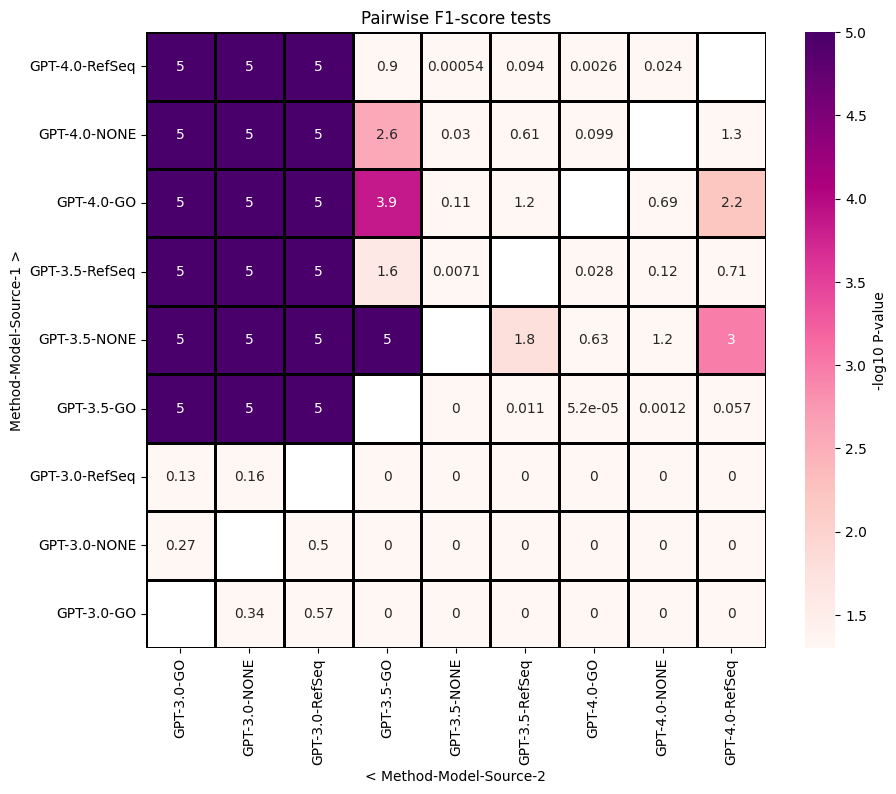

In [212]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap_data_log = np.log10(heatmap_data)
heatmap_data_log[heatmap_data_log < 0] = -heatmap_data_log[heatmap_data_log < 0]

diag_value = np.nan
shape = heatmap_data_log.shape
#print(shape)
for i in range(min(shape)):
#    print(f'i: {i}')
#    print(f'max(shape)-i: {max(shape)-1-i}')
    heatmap_data_log.iloc[i, max(shape)-1-i] = diag_value

#mask = heatmap_data_log > 1.3
#mask=~mask, 
sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-value'}, linewidths=1, linecolor='black', vmin=1.3)
#sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-Value'}, linewidths=1, linecolor='black', vmin=1.3)

plt.title("Pairwise F1-score tests")
plt.grid(False)
plt.savefig("TALISMAN_ttest_f1.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [213]:
print(f'len: {len(all_possible_pairs)}')
print(f'len: {len(all_possible_pairs[5])}')
print(f'len: {len(all_possible_pairs[5][0])}')
print(f'len: {len(all_possible_pairs[5][1])}')
print(type(all_possible_pairs[5][0][0]))
all_possible_pairs[5][0][0]
#all_possible_pairs[5][1]

len: 81
len: 2
len: 2
len: 2
<class 'tuple'>


('GPT', 3.0, 'GO')

In [214]:
metrics = ['precision']

t_test_results_precision = []
pairs_with_na = []
all_possible_pairs = list(product(method_model_combinations, repeat=2))

# Perform pairwise t-tests for each metric
for metric in metrics:
    filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')

    for (key1, group1), (key2, group2) in all_possible_pairs:#existing_combinations:#:#all_possible_combinations_list:#
        print(f'1: {key1}\t2: {key2}')

        group1_metric = pd.to_numeric(group1[metric], errors='coerce').dropna()
        group2_metric = pd.to_numeric(group2[metric], errors='coerce').dropna()

        t_stat, p_value = ttest_ind(group1_metric, group2_metric, 
                                    nan_policy='propagate', permutations=100000, alternative='greater',
                                   equal_var='false')
        
        # Store the results
        t_test_results_precision.append({
            'Method1': key1[0],
            'Model1': key1[1],
            'Source1': key1[2],
            'Method2': key2[0],
            'Model2': key2[1],
            'Source2': key2[2],
            'Metric': metric,
            'T-Statistic': t_stat,
            'P-Value': p_value,
        })
        
        if key1 == ('GPT', 3.5, 'NONE') and key2 == ('GPT', 3.0, 'NONE'):
            print(f'1: {key1}\t2: {key2}')
            testres = ttest_ind(group1[metric].dropna(), group2[metric].dropna(), nan_policy='propagate', permutations=10000, alternative='greater',equal_var='false')
            print(str(testres))
            print(type(group1[metric]))
            print(group1_metric)
            print(group2_metric)
            print(group1_metric[group1_metric.isna()])
            print(group2_metric[group2_metric.isna()])
            print(f'1: {group1[metric].isna().sum()}\t2: {group2_metric.isna().sum()}')
            print(f'group1: {len(group1_metric)}, group2: {len(group2_metric)}')
            print(t_test_results_precision[-1])

# Create a DataFrame to display the results
t_test_results_precision_df = pd.DataFrame(t_test_results_precision)


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'GO')


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_7257/4013416420.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.5, 'GO')


In [215]:
t_test_results_precision_df['Method-Model-Source-1 >'] = t_test_results_precision_df['Method1'].str.upper() + '-' + t_test_results_precision_df['Model1'].astype(str) + '-' + t_test_results_df['Source1']
t_test_results_precision_df['< Method-Model-Source-2'] = t_test_results_precision_df['Method2'].str.upper() + '-' + t_test_results_precision_df['Model2'].astype(str) + '-' + t_test_results_df['Source2']

#print(significant_results['Method+Model+Source 1'])

# Pivot the dataframe
heatmap_data = t_test_results_precision_df.pivot(index='Method-Model-Source-1 >', columns='< Method-Model-Source-2', values='P-Value')
heatmap_data = heatmap_data[heatmap_data.index]
heatmap_data = heatmap_data.iloc[::-1]
print(heatmap_data.shape)
heatmap_data

(9, 9)


< Method-Model-Source-2,GPT-3.0-GO,GPT-3.0-NONE,GPT-3.0-RefSeq,GPT-3.5-GO,GPT-3.5-NONE,GPT-3.5-RefSeq,GPT-4.0-GO,GPT-4.0-NONE,GPT-4.0-RefSeq
Method-Model-Source-1 >,,,,,,,,,
GPT-4.0-RefSeq,0.000010,0.000010,0.000010,0.555004,0.997250,0.931361,0.758662,0.909351,0.502085
GPT-4.0-NONE,0.000010,0.000010,0.000010,0.125849,0.929271,0.599124,0.234428,0.498305,0.091889
GPT-4.0-GO,0.000010,0.000010,0.000010,0.297687,0.989000,0.824582,0.500255,0.768682,0.241028
GPT-3.5-RefSeq,0.000010,0.000010,0.000010,0.093399,0.868791,0.501575,0.174388,0.400056,0.068969
GPT-3.5-NONE,0.000010,0.000010,0.000010,0.006220,0.499225,0.130939,0.011820,0.072039,0.003490
GPT-3.5-GO,0.000010,0.000010,0.000010,0.499265,0.993900,0.907051,0.703003,0.873301,0.443536
GPT-3.0-RefSeq,0.353616,0.991140,0.499655,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-NONE,0.002020,0.501625,0.008100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-GO,0.501075,0.998020,0.643554,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


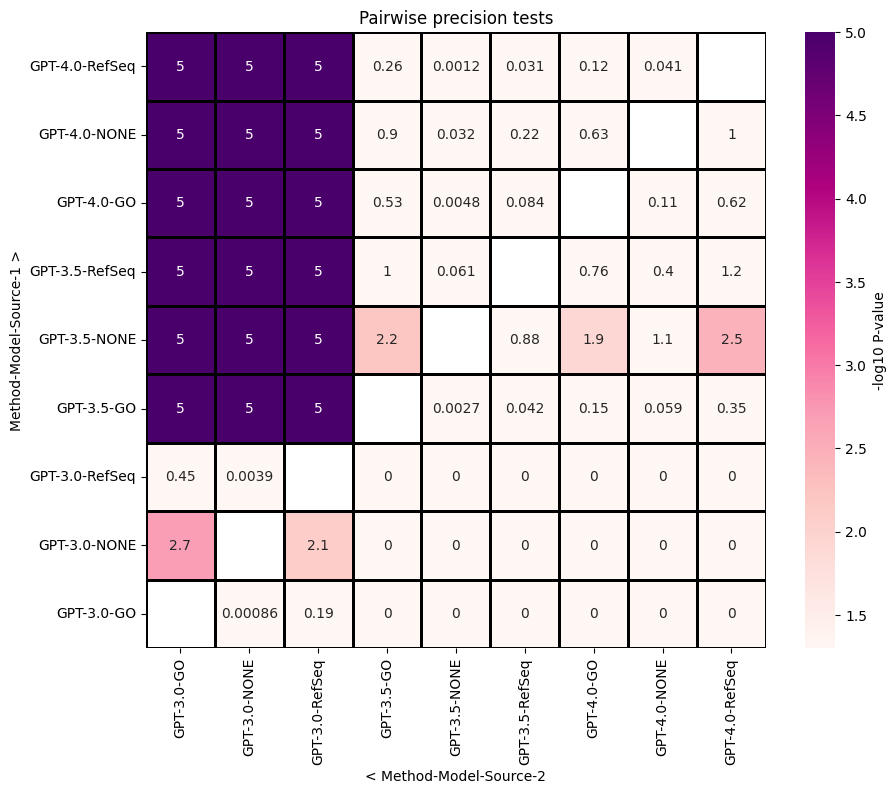

In [216]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap_data_log = np.log10(heatmap_data)
heatmap_data_log[heatmap_data_log < 0] = -heatmap_data_log[heatmap_data_log < 0]

diag_value = np.nan
shape = heatmap_data_log.shape
#print(shape)
for i in range(min(shape)):
#    print(f'i: {i}')
#    print(f'max(shape)-i: {max(shape)-1-i}')
    heatmap_data_log.iloc[i, max(shape)-1-i] = diag_value

#mask = heatmap_data_log > 1.3
#mask=~mask, 
sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-value'}, linewidths=1, linecolor='black', vmin=1.3)
#sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-Value'}, linewidths=1, linecolor='black', vmin=1.3)

plt.title("Pairwise precision tests")
plt.grid(False)
plt.savefig("TALISMAN_ttest_precision.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [217]:
metrics = ['recall']

t_test_results_recall = []
pairs_with_na = []
all_possible_pairs = list(product(method_model_combinations, repeat=2))

# Perform pairwise t-tests for each metric
for metric in metrics:
    filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')

    for (key1, group1), (key2, group2) in all_possible_pairs:#existing_combinations:#:#all_possible_combinations_list:#
        print(f'1: {key1}\t2: {key2}')

        group1_metric = pd.to_numeric(group1[metric], errors='coerce').dropna()
        group2_metric = pd.to_numeric(group2[metric], errors='coerce').dropna()

        t_stat, p_value = ttest_ind(group1_metric, group2_metric, 
                                    nan_policy='propagate', permutations=100000, alternative='greater',
                                   equal_var='false')
        
        # Store the results
        t_test_results_recall.append({
            'Method1': key1[0],
            'Model1': key1[1],
            'Source1': key1[2],
            'Method2': key2[0],
            'Model2': key2[1],
            'Source2': key2[2],
            'Metric': metric,
            'T-Statistic': t_stat,
            'P-Value': p_value,
        })
        
        if key1 == ('GPT', 3.5, 'NONE') and key2 == ('GPT', 3.0, 'NONE'):
            print(f'1: {key1}\t2: {key2}')
            testres = ttest_ind(group1[metric].dropna(), group2[metric].dropna(), nan_policy='propagate', permutations=10000, alternative='greater',equal_var='false')
            print(str(testres))
            print(type(group1[metric]))
            print(group1_metric)
            print(group2_metric)
            print(group1_metric[group1_metric.isna()])
            print(group2_metric[group2_metric.isna()])
            print(f'1: {group1[metric].isna().sum()}\t2: {group2_metric.isna().sum()}')
            print(f'group1: {len(group1_metric)}, group2: {len(group2_metric)}')
            print(t_test_results_recall[-1])

# Create a DataFrame to display the results
t_test_results_recall_df = pd.DataFrame(t_test_results_recall)


/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_7257/3754891854.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 3.5, 'RefSeq')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'GO')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'NONE')
1: ('GPT', 3.0, 'NONE')	2: ('GPT', 4.0, 'RefSeq')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'RefSeq')	2: ('GPT', 3.0, 'RefSeq')
1: (

In [218]:
t_test_results_recall_df['Method-Model-Source-1 >'] = t_test_results_recall_df['Method1'].str.upper() + '-' + t_test_results_recall_df['Model1'].astype(str) + '-' + t_test_results_df['Source1']
t_test_results_recall_df['< Method-Model-Source-2'] = t_test_results_recall_df['Method2'].str.upper() + '-' + t_test_results_recall_df['Model2'].astype(str) + '-' + t_test_results_df['Source2']

#print(significant_results['Method+Model+Source 1'])

# Pivot the dataframe
heatmap_data = t_test_results_recall_df.pivot(index='Method-Model-Source-1 >', columns='< Method-Model-Source-2', values='P-Value')
heatmap_data = heatmap_data[heatmap_data.index]
heatmap_data = heatmap_data.iloc[::-1]
print(heatmap_data.shape)
heatmap_data

(9, 9)


< Method-Model-Source-2,GPT-3.0-GO,GPT-3.0-NONE,GPT-3.0-RefSeq,GPT-3.5-GO,GPT-3.5-NONE,GPT-3.5-RefSeq,GPT-4.0-GO,GPT-4.0-NONE,GPT-4.0-RefSeq
Method-Model-Source-1 >,,,,,,,,,
GPT-4.0-RefSeq,0.000020,0.000010,0.000010,0.104179,0.999510,0.719993,0.999660,0.958750,0.501005
GPT-4.0-NONE,0.000010,0.000010,0.000010,0.001470,0.941991,0.133119,0.949821,0.499005,0.041800
GPT-4.0-GO,0.000010,0.000010,0.000010,0.000010,0.490895,0.002770,0.500205,0.050849,0.000270
GPT-3.5-RefSeq,0.000010,0.000010,0.000010,0.036470,0.995910,0.501285,0.997040,0.868471,0.282847
GPT-3.5-NONE,0.000010,0.000010,0.000010,0.000020,0.501085,0.004220,0.508535,0.058259,0.000550
GPT-3.5-GO,0.001150,0.000010,0.000010,0.496885,1.000000,0.962630,0.999990,0.998320,0.895931
GPT-3.0-RefSeq,0.964630,0.389666,0.499425,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-NONE,0.983270,0.498255,0.609444,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
GPT-3.0-GO,0.502105,0.016870,0.035500,0.998730,1.000000,1.000000,1.000000,1.000000,1.000000


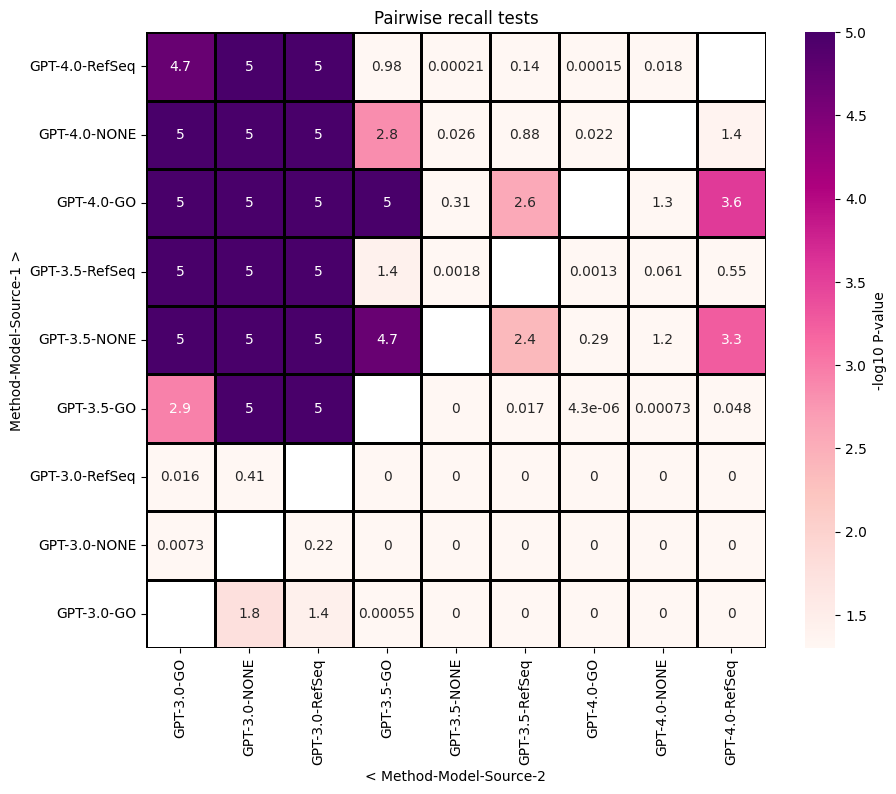

In [226]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap_data_log = np.log10(heatmap_data)
heatmap_data_log[heatmap_data_log < 0] = -heatmap_data_log[heatmap_data_log < 0]

diag_value = np.nan
shape = heatmap_data_log.shape
#print(shape)
for i in range(min(shape)):
#    print(f'i: {i}')
#    print(f'max(shape)-i: {max(shape)-1-i}')
    heatmap_data_log.iloc[i, max(shape)-1-i] = diag_value

#mask = heatmap_data_log > 1.3
#mask=~mask, 
sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-value'}, linewidths=1, linecolor='black', vmin=1.3)
#sns.heatmap(heatmap_data_log, annot=True, cmap='RdPu', cbar_kws={'label': '-log10 P-Value'}, linewidths=1, linecolor='black', vmin=1.3)

plt.title("Pairwise recall tests")
plt.grid(False)
plt.savefig("TALISMAN_ttest_recall.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [225]:
metrics = ['f1_score']

mu_test_results = []
pairs_with_na = []
all_possible_pairs = list(product(method_model_combinations, repeat=2))

# Perform pairwise t-tests for each metric
for metric in metrics:
    filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')

    for (key1, group1), (key2, group2) in all_possible_pairs:#existing_combinations:#:#all_possible_combinations_list:#
        print(f'1: {key1}\t2: {key2}')

        group1_metric = pd.to_numeric(group1[metric], errors='coerce').dropna()
        group2_metric = pd.to_numeric(group2[metric], errors='coerce').dropna()

        mu_stat, p_value = mannwhitneyu(group1_metric, group2_metric, alternative='greater', method='exact')
        #ttest_ind(group1_metric, group2_metric, 
        #                            nan_policy='propagate', permutations=100000, alternative='greater',
        #                           equal_var='false')
        
        # Store the results
        mu_test_results.append({
            'Method1': key1[0],
            'Model1': key1[1],
            'Source1': key1[2],
            'Method2': key2[0],
            'Model2': key2[1],
            'Source2': key2[2],
            'Metric': metric,
            'MU-Statistic': mu_stat,
            'P-Value': p_value,
        })



# Create a DataFrame to display the results
mu_test_results_df = pd.DataFrame(mu_test_results)

# Display the results
#print("Pairwise t-test results:")
#print(significant_results)

#print("pairs_with_na")
#print(pairs_with_na)

/var/folders/hx/svkm0dlj0bd9689lm21_7fyw0000gs/T/ipykernel_7257/1311655240.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_dropna[metric] = pd.to_numeric(filtered_data_dropna[metric], errors='coerce')


1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'NONE')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.0, 'RefSeq')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'GO')
1: ('GPT', 3.0, 'GO')	2: ('GPT', 3.5, 'NONE')



KeyboardInterrupt

